# Problem 8:  Flow cytometry

The method of flow cytometry is a rapid and cost-effective method to study large samples of cells.
Every cell is measured for multiple quantities. 

There are two possible objectives:
One is to observe a sample of cells, and determine what the groupings are. 
This is outside our current assignment. 
Methods including "k-means" can be used for this.

The other possible objective is to develop a predictive model.
Suppose you have a training set of cells where you know the cells are one of two types -- say, activate and inactive immune cells.
You observe a new cell, not from the training set. 
Is it active or not?
For this question, we will use the method of __k-nearest-neighbors__.

We will first use synthetic data (where we can measure true accuracy) and then real data.

The following code generates synthetic  FACS data:

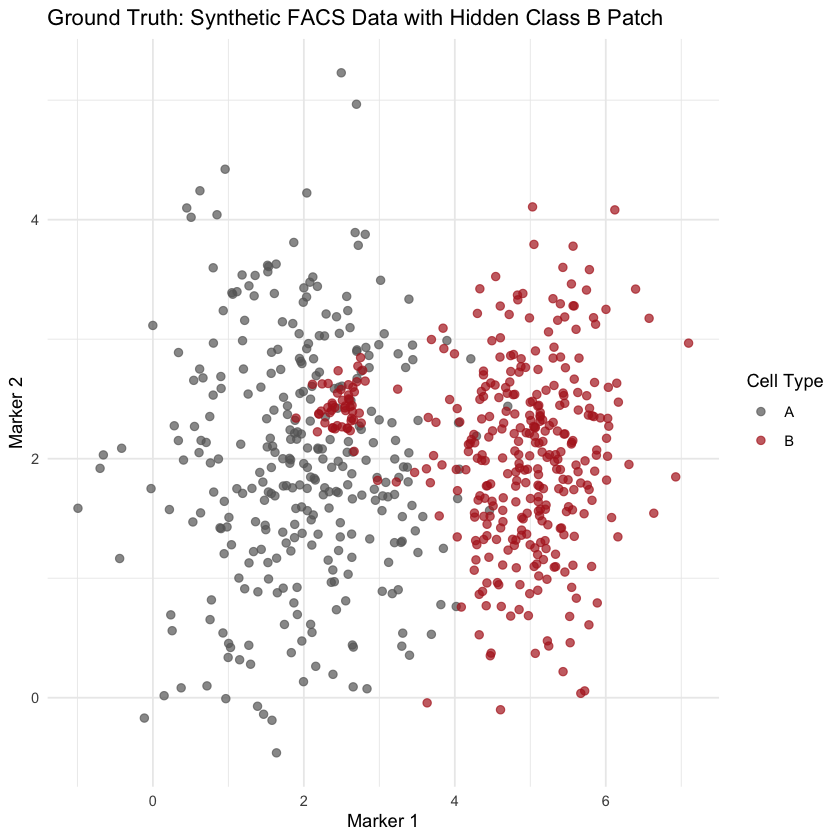

In [1]:
# Load required packages
library(ggplot2)
library(class)  # for knn
set.seed(42)

# === Function to Generate Synthetic FACS Data ===
generate_facs_data <- function(n = 350) {
  # Class A: Large Gaussian cloud
  classA <- data.frame(
    Marker1 = rnorm(n - 40, mean = 2, sd = 1.0),
    Marker2 = rnorm(n - 40, mean = 2, sd = 1.0),
    Label = factor(rep("A", n - 40))
  )
  
  # Class B1: Tiny tight cluster inside A
  classB1 <- data.frame(
    Marker1 = rnorm(50, mean = 2.5, sd = 0.2),
    Marker2 = rnorm(50, mean = 2.5, sd = 0.2),
    Label = factor(rep("B", 50))
  )

  # Class B2:
  classB2 <- data.frame(
    Marker1 = rnorm(n - 40, mean = 5.0, sd = 0.6),
    Marker2 = rnorm(n - 40, mean = 2, sd = 0.8),
    Label = factor(rep("B", n - 40))
  )
  
  rbind(classA, classB1, classB2)

}

# Generate and plot a fresh dataset
data <- generate_facs_data()

ggplot(data, aes(x = Marker1, y = Marker2, color = Label)) +
  geom_point(size = 2, alpha = 0.7) +
  scale_color_manual(values = c("A" = "gray40", "B" = "firebrick")) +
  theme_minimal() +
  labs(title = "Ground Truth: Synthetic FACS Data with Hidden Class B Patch",
       x = "Marker 1", y = "Marker 2", color = "Cell Type")  

## Question i

Generate two data sets.
For now, choose `k = 10`.
Use the first to train the knn model with `k = 10`, and make predictions fo the 2nd dataset.

Define the __accuracy__ as the number of misclassified cells divided by the total number of cells.
Compute the accuracy.

In [2]:
k <- 10
training_data <- generate_facs_data()
testing_data <- generate_facs_data()
pred <- knn(training_data[,1:2], testing_data[,1:2], cl = training_data$Label, k = k)
acc <- mean(pred == testing_data$Label)

cat("Accuracy with k =", k, ":", acc, "\n")

Accuracy with k = 10 : 0.9208955 


## Question ii

Read about the [k-nearest-neighbors model](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) on wikipedia or elsewhere. 
In words, what is the meaning of $k$?

Inspect the data.
What value of $k$ do you think will maximize accuracy?

## Question iii

Perform a sweep over k values 1 to 60, `k_values <- 1:60`, repeating the above accuracy calculation.
Plot accuracy versus k. 
What is the k that maximizes accuracy?

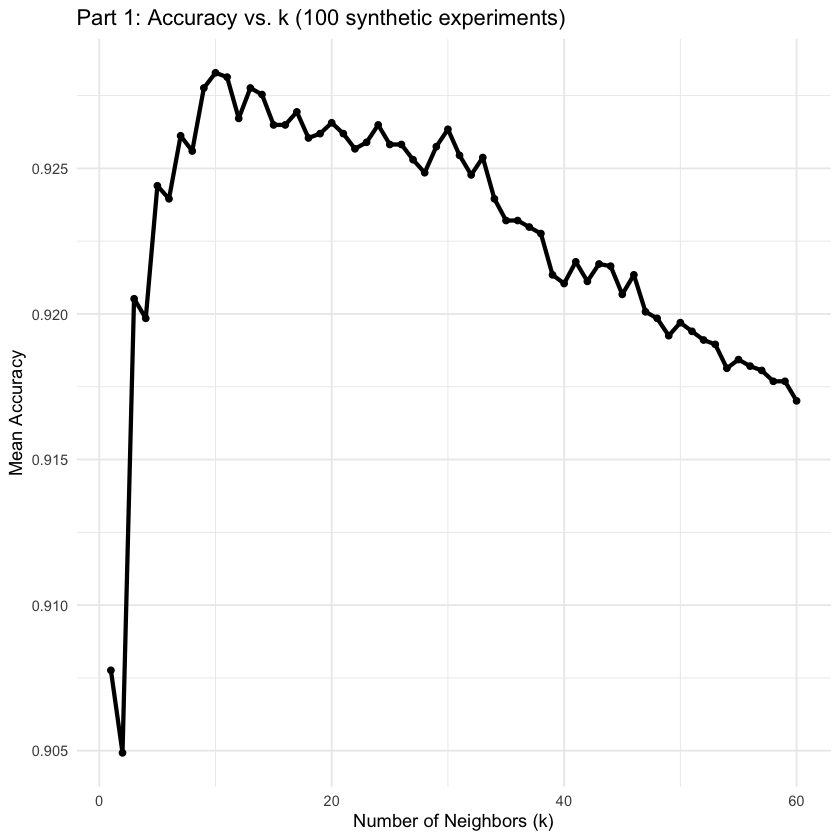

In [3]:
# === PART 1: Simulate 100 Experiments with kNN ===
k_values <- 1:60
# k_values <- c(1:30, seq(35, 100, by = 5))
results <- data.frame()

for (i in 1:100) {
  data <- generate_facs_data()
  idx <- sample(1:nrow(data), 0.8 * nrow(data))
  train <- data[idx, ]
  test  <- data[-idx, ]
  
  for (k in k_values) {
    pred <- knn(train[,1:2], test[,1:2], cl = train$Label, k = k)
    acc <- mean(pred == test$Label)
    results <- rbind(results, data.frame(Run = i, k = k, Accuracy = acc))
  }
}

# Average accuracy over 100 runs
mean_acc <- aggregate(Accuracy ~ k, data = results, mean)

# Plot Part 1
ggplot(mean_acc, aes(x = k, y = Accuracy)) +
  geom_line(linewidth = 1.2) +
  geom_point() +
  theme_minimal() +
  labs(title = "Part 1: Accuracy vs. k (100 synthetic experiments)",
       x = "Number of Neighbors (k)", y = "Mean Accuracy")

## Question iii

In this part, assume you do not have the ability to generate a 2nd dataset.
This is more realistic, since if you have the 2nd dataset, you would simply use it to train the model.

Use cross-validation to determine the $k$ that maximizes accuracy.
How does the optimal $k$ compare to the one you found in the previous part?
You may use 10-fold cross-validation or leave-one-out cross-validation.

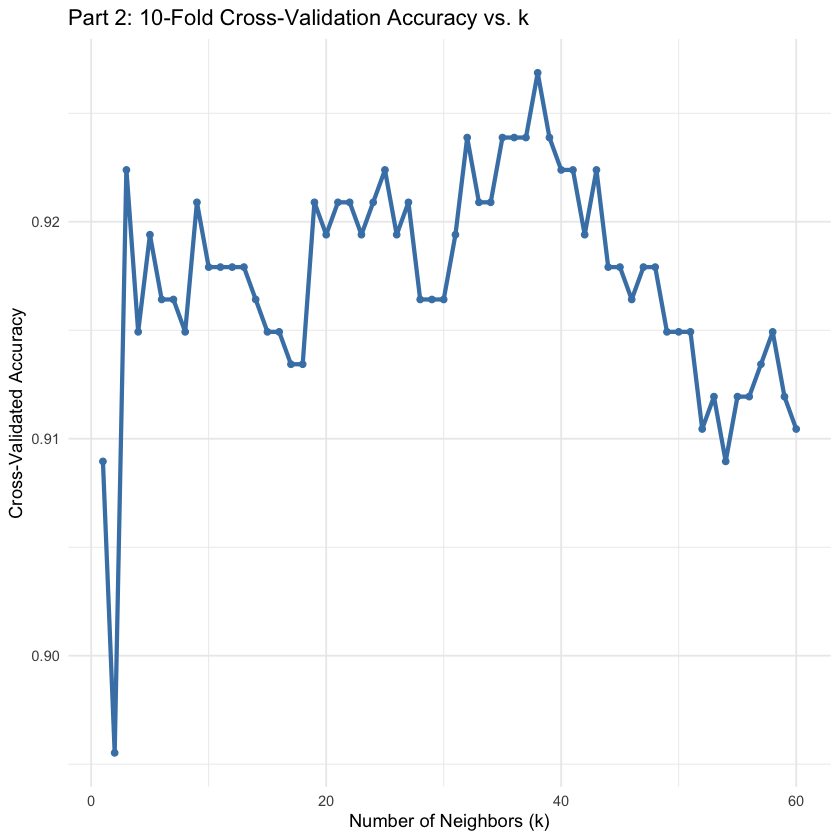

In [4]:
# === PART 2: Manual 10-Fold Cross-Validation on a Single Dataset ===
data <- generate_facs_data()
folds <- sample(rep(1:10, length.out = nrow(data)))
cv_results <- data.frame()

for (k in k_values) {
  fold_accuracies <- c()
  
  for (f in 1:10) {
    test_idx <- which(folds == f)
    train_data <- data[-test_idx, ]
    test_data  <- data[test_idx, ]
    
    pred <- knn(train_data[,1:2], test_data[,1:2], cl = train_data$Label, k = k)
    acc <- mean(pred == test_data$Label)
    fold_accuracies <- c(fold_accuracies, acc)
  }
  
  cv_results <- rbind(cv_results, data.frame(k = k, Accuracy = mean(fold_accuracies)))
}

# Plot Part 2
ggplot(cv_results, aes(x = k, y = Accuracy)) +
  geom_line(linewidth = 1.2, color = "steelblue") +
  geom_point(color = "steelblue") +
  theme_minimal() +
  labs(title = "Part 2: 10-Fold Cross-Validation Accuracy vs. k",
       x = "Number of Neighbors (k)", y = "Cross-Validated Accuracy")

